In [1]:
import pandas as pd
import numpy as np
from scipy.io import arff
import tensorflow as tf
from tensorflow.keras import layers, backend 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, concatenate, BatchNormalization, LeakyReLU, Flatten
import joblib

import time
from typing import Tuple, List
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
def split_df_to_train_val(df, ratio):
    mask = np.random.rand(len(df)) < ratio
    df_train = df[mask]
    df_val = df[~mask]
    return df_train, df_val

In [4]:
diab_arf = arff.loadarff('gdrive/MyDrive/DL/Assignment_4/diabetes.arff')
diab_df = pd.DataFrame(diab_arf[0])
diab_df.replace(to_replace=b'tested_negative', value=-1, inplace=True)
diab_df.replace(to_replace=b'tested_positive', value=1, inplace=True)
# the values must be scaled to the range [-1,1] to match the output of the generator model
def scaler(df):
  for column in df:
    max = df[column].max()
    min = df[column].min()
    col = 2*((df[column] - min)/(max - min)) - 1
    df[column] = col
  return df
diab_df = scaler(diab_df)
diab_df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,-0.294118,0.487437,0.180328,-0.292929,-1.000000,0.001490,-0.531170,-0.033333,1.0
1,-0.882353,-0.145729,0.081967,-0.414141,-1.000000,-0.207154,-0.766866,-0.666667,-1.0
2,-0.058824,0.839196,0.049180,-1.000000,-1.000000,-0.305514,-0.492741,-0.633333,1.0
3,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,-1.000000,-1.0
4,-1.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000,1.0


In [5]:
df_train, df_test = split_df_to_train_val(diab_df, 0.7)
y_train = df_train.pop('class')
y_test = df_test.pop('class')

df_train.head()

,preg,plas,pres,skin,insu,mass,pedi,age
0,-0.294118,0.487437,0.180328,-0.292929,-1.000000,0.001490,-0.531170,-0.033333
1,-0.882353,-0.145729,0.081967,-0.414141,-1.000000,-0.207154,-0.766866,-0.666667
3,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,-1.000000
4,-1.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000
6,-0.647059,-0.216080,-0.180328,-0.353535,-0.791962,-0.076006,-0.854825,-0.833333


In [42]:
# rf.fit(df_train, y_train)
# rf.oob_score_

# using cross-validation and grid-search

rf = RandomForestClassifier()
parameters = {
    'max_features': ('auto', 'sqrt', 10, 12, 20, 30),
    'max_depth': (5, 10, 15, None),
    'n_estimators': (100, 200, 500, 1000, 2000)
}
gs_rf = GridSearchCV(estimator=rf, param_grid=parameters, cv=5, n_jobs=-1, verbose=3)
gs_rf.fit(df_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  5.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [43]:
gs_rf.best_params_

{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 2000}

In [44]:
gs_rf.best_score_

0.7693620844564241

In [45]:
p = gs_rf.predict(df_test)
confusion_matrix(y_test.values, p)

array([[138,  31],
       [ 21,  49]])

In [46]:
print(classification_report(y_test.values, p,labels=[1,-1]))

              precision    recall  f1-score   support

           1       0.61      0.70      0.65        70
          -1       0.87      0.82      0.84       169

    accuracy                           0.78       239
   macro avg       0.74      0.76      0.75       239
weighted avg       0.79      0.78      0.79       239



In [6]:
# joblib.dump(gs_rf, "/content/gdrive/MyDrive/DL/Assignment_4/random_forest_cred.joblib")
# gs_rf = joblib.load("/content/gdrive/MyDrive/DL/Assignment_4/random_forest_cred.joblib")
# joblib.dump(gs_rf, "/content/gdrive/MyDrive/DL/Assignment_4/random_forest_diab.joblib")
gs_rf = joblib.load("/content/gdrive/MyDrive/DL/Assignment_4/random_forest_diab.joblib")

In [9]:
class GAN:
    def __init__(self):
        self.latent_dim = 10
        self.generator_vector_size = 8
        self.discriminator_input_shape = (self.generator_vector_size,)

        self.generator = self.make_generator_model()
        self.discriminator = self.make_discriminator_model()
        self.gan = self.combime_gan(self.generator, self.discriminator)

    def combime_gan(self, g_model, d_model):
        # make weights in the discriminator not trainable
        d_model.trainable = False

        g_input = Input(shape=(self.latent_dim,))
        c_input = Input(shape=(1,))

        
        g_sample = g_model([g_input, c_input])

        # c_input = Input(shape=(1,))
        # c_input = Input(shape=(1,))
        # print(g_sample)
        # print(g_sample.shape)
        # proto_tensor = tf.make_tensor_proto(g_sample)  # convert `tensor a` to a proto tensor
        
        # y =  gs_rf.predict_proba(tf.make_ndarray(proto_tensor))[:,0]  # evaluate Y by running RF classifier
        # # shuffle c and y
        # # idx = np.random.randint(0, c.shape, n_samples)
        # # for i, ix in enumerate(range(idx)):
        # #   if ix == 1:
        # #     tmp = c[i]
        # #     c[i] = y[i]
        # #     y[i] = tmp

        d_desision = d_model([g_sample, c_input, c_input])

        gan_model = Model([g_input, c_input], d_desision)
        opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
        gan_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        # connect generator and discriminator
        # model = tf.keras.Sequential()
        # model.add(g_model)
        # model.add(d_model)
        # opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
        # model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return gan_model

    def make_generator_model(self):
        input_noise = Input(shape=(self.latent_dim,))
        c_input = Input(shape=(1,))
        concat_layer_c = concatenate([input_noise, c_input]) 
        dense_1 = Dense(30, use_bias=True)(concat_layer_c)
        dense_1_bn = BatchNormalization()(dense_1)
        dense_1_lr = LeakyReLU()(dense_1_bn)
        dense_2 = Dense(15)(dense_1_lr)
        dense_2_bn = BatchNormalization()(dense_2)
        dense_2_lr = LeakyReLU()(dense_2_bn)
        final_layer = Dense(self.generator_vector_size, activation='tanh')(dense_2_lr)
        # concat_layer = concatenate([final_layer, c_input])
        model = Model(inputs=[input_noise, c_input], outputs=final_layer)

        # final_model_1 = concatenate([lyrics_model, bn2])
        # final_model = Dense(units=vocab_size, activation='softmax')(final_model_1)
        # self.model = Model(inputs=[input_lyrics, input_midi], outputs=final_model)
        # self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        # self.model.summary()


        # model = tf.keras.Sequential()
        # model.add(layers.Dense(30, use_bias=True, input_dim=self.latent_dim))
        # model.add(layers.BatchNormalization())
        # model.add(layers.LeakyReLU())

        # model.add(layers.Dense(15))
        # model.add(layers.BatchNormalization())
        # model.add(layers.LeakyReLU())
        # model.add(layers.Dense(self.generator_vector_size, activation='tanh'))
        model.summary()
        return model

        # noise = tf.keras.layers.Input(shape=(self.latent_dim,))
        # g_rows = model(noise)
        # return tf.keras.Model(noise, g_rows)
        # return model

    def make_discriminator_model(self):

        input_sample = Input(shape=self.discriminator_input_shape,)
        cy1_input = Input(shape=(1,))
        cy2_input = Input(shape=(1,))
        
        # --------- arc1
        # dense_1 = Dense(32, use_bias=True)(input_sample)
        # dense_1_lr = LeakyReLU()(dense_1)
        # dense_1_do = Dropout(0.2)(dense_1_lr)
        # dense_2 = Dense(16)(dense_1_do)
        # dense_2_lr = LeakyReLU()(dense_2)
        # dense_2_do = Dropout(0.2)(dense_2_lr)
        # flatten = Flatten()(dense_2_do)
        # concat_layer_c = concatenate([dense_2_do, cy1_input]) 
        # cy1_score = Dense(1, activation='sigmoid')(concat_layer_c)
        # concat_layer_y = concatenate([dense_2_do, cy2_input]) 
        # cy2_score = Dense(1, activation='sigmoid')(concat_layer_y)
        # concat_layer_final = concatenate([cy1_score, cy2_score]) 
        # final_layer = Dense(1, activation='sigmoid')(concat_layer_final)
        # # concat_layer = concatenate([dense_2_do, c_input, y_input])        
        # model = Model(inputs=[input_sample, cy1_input, cy2_input], outputs=final_layer)

        # --------- arc2
        # dense_1 = Dense(32, use_bias=True)(input_sample)
        # dense_1_lr = LeakyReLU()(dense_1)
        # dense_1_do = Dropout(0.2)(dense_1_lr)
        # dense_2 = Dense(16)(dense_1_do)
        # dense_2_lr = LeakyReLU()(dense_2)
        # dense_2_do = Dropout(0.2)(dense_2_lr)
        # flatten = Flatten()(dense_2_do)
        # concat_layer_c = concatenate([dense_2_do, cy1_input, cy2_input]) 
        # final_layer = Dense(1, activation='sigmoid')(concat_layer_c)
        # # concat_layer = concatenate([dense_2_do, c_input, y_input])        
        # model = Model(inputs=[input_sample, cy1_input, cy2_input], outputs=final_layer)


        # --------- arc3
        concat_layer_c = concatenate([input_sample, cy1_input, cy2_input])
        dense_1 = Dense(32, use_bias=True)(input_sample)
        dense_1_lr = LeakyReLU()(dense_1)
        dense_1_do = Dropout(0.2)(dense_1_lr)
        dense_2 = Dense(16)(dense_1_do)
        dense_2_lr = LeakyReLU()(dense_2)
        dense_2_do = Dropout(0.2)(dense_2_lr)
        flatten = Flatten()(dense_2_do)
        # layer_final_sm = Dense(2, activation='softmax')(flatten)
        final_layer = Dense(1, activation='sigmoid')(flatten)
        # concat_layer = concatenate([dense_2_do, c_input, y_input])        
        model = Model(inputs=[input_sample, cy1_input, cy2_input], outputs=final_layer)

        # --------- arc4
        # dense_1 = Dense(32, use_bias=True)(input_sample)
        # dense_1_lr = LeakyReLU()(dense_1)
        # dense_1_do = Dropout(0.2)(dense_1_lr)
        # dense_2 = Dense(16)(dense_1_do)
        # dense_2_lr = LeakyReLU()(dense_2)
        # dense_2_do = Dropout(0.2)(dense_2_lr)
        # flatten = Flatten()(dense_2_do)
        # concat_layer_c = concatenate([dense_2_do, cy1_input]) 
        # cy1_score = Dense(1, activation='sigmoid')(concat_layer_c)
        # concat_layer_y = concatenate([dense_2_do, cy2_input]) 
        # cy2_score = Dense(1, activation='sigmoid')(concat_layer_y)
        # concat_layer_final = concatenate([cy1_score, cy2_score]) 
        # concat_layer_final_sm = Dense(2, activation='softmax')(concat_layer_final)
        # final_layer = Dense(1, activation='sigmoid')(concat_layer_final)
        # # concat_layer = concatenate([dense_2_do, c_input, y_input])        
        # model = Model(inputs=[input_sample, cy1_input, cy2_input], outputs=final_layer)



        # dense_2 = Dense(self.generator_vector_size, activation='tanh')(dense_2_lr)
        # final_layer = tanh()(dense_2)
        # model = Model(inputs=[input_noise, c_input], outputs=final_layer)      

        # model = tf.keras.Sequential()
        # model.add(layers.Dense(32, use_bias=True, input_shape=self.discriminator_input_shape))
        # # model.add(layers.Dense(32, use_bias=False, input_shape=(8,)))
        # model.add(layers.LeakyReLU())
        # model.add(layers.Dropout(0.2))

        # model.add(layers.Dense(16))
        # model.add(layers.LeakyReLU())
        # model.add(layers.Dropout(0.2))

        # model.add(layers.Flatten())
        # model.add(layers.Dense(1, activation='sigmoid'))
        opt = tf.keras.optimizers.Adam(lr=0.00015, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        model.summary()
        return model

        # g_rows = tf.keras.layers.Input(shape=self.discriminator_input_shape)
        # validity = model(g_rows)
        # return tf.keras.Model(g_rows, validity)


    # def generate_real_x_y(self, data: np.ndarray, n_samples: int) -> Tuple[np.ndarray, np.ndarray]:
    #     y_real = np.ones((n_samples, 1))
    #     idx = np.random.randint(0, data.shape[0], n_samples)
    #     x_real = data[idx]
    #     return x_real, y_real

    # def generate_fake_x_y(self, n_samples: int) -> Tuple[np.ndarray, np.ndarray]:
    #     y_fake = np.zeros((n_samples, 1))
    #     noise = np.random.normal(0, 1, (n_samples, self.latent_dim))
    #     x_fake = self.generator.predict(noise)
    #     return x_fake, y_fake

    def train(self, epochs, batch_size=8):
        # (X_train, _), (_, _) = mnist.load_data()
        # X_train = X_train / 127.5 - 1.
        # X_train = np.expand_dims(X_train, axis=3)
        # X_train = df.values
        valid = np.ones((batch_size, 1))
        invalid = np.zeros((batch_size, 1))
        valid_twice = np.ones((batch_size * 2, 1))
        # fake = np.zeros((batch_size, 1))
        d_losses = np.zeros((epochs, 1))
        d_accuracies = np.zeros((epochs, 1))
        # d_fake_losses = np.zeros((epochs, 1))
        # d_fake_accuracies = np.zeros((epochs, 1))
        # d_real_losses = np.zeros((epochs, 1))
        # d_real_accuracies = np.zeros((epochs, 1))
        g_losses = np.zeros((epochs, 1))
        g_accuracies = np.zeros((epochs, 1))
        best_epoch = 0

        for i, epoch in enumerate(range(epochs)):
            # prepare samples
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            c_1 = np.random.random((batch_size, ))
            samples_1 = self.generator.predict([noise, c_1])
            y_1 =  gs_rf.predict_proba(samples_1)[:,0]  # evaluate Y by running RF classifier

            d_loss, d_acc = self.discriminator.train_on_batch([samples_1, c_1, y_1], valid)

            c_2 = np.random.random((batch_size, ))
            samples_2 = self.generator.predict([noise, c_2])
            y_2 =  gs_rf.predict_proba(samples_2)[:,0]  # evaluate Y by running RF classifier

            d_loss, d_acc = self.discriminator.train_on_batch([samples_2, y_2, c_2], invalid)

            # create training set for the discriminator
            # samples, y, c = np.vstack((samples_1, samples_2)), np.vstack((y_1, c_2)), np.vstack((y_2, c_1))
            # update discriminator model weights
            # d_loss, d_acc = self.discriminator.train_on_batch([samples, y, c], valid_twice)

            # # shuffle c and y
            # idx = np.random.randint(2, size=batch_size)
            # # print(idx)
            # for i in range(batch_size):
            #   if idx[i] == 0 :
            #     tmp = c[i]
            #     c[i] = y[i]
            #     y[i] = tmp

            # d_loss, d_acc = self.discriminator.train_on_batch([samples, c, y], idx)


            # np.stack((samples,c,y), axis=-1)

            # # create training set for the discriminator
            # x, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
            # # update discriminator model weights
            # d_loss, d_acc = self.discriminator.train_on_batch(x, y)

            # # evaluate discriminator on real examples
            # x_real, y_real = self.generate_real_x_y(X_train, batch_size)
            # d_loss_real, d_acc_real = self.discriminator.evaluate(x_real, y_real, verbose=0)
            # # evaluate discriminator on fake examples
            # x_fake, y_fake = self.generate_fake_x_y(batch_size)
            # d_loss_fake, d_acc_fake = self.discriminator.evaluate(x_fake, y_fake, verbose=0)

            # d_fake_losses[i] = d_loss_fake
            # d_real_losses[i] = d_loss_real
            # d_fake_accuracies[i] = d_acc_fake
            # d_real_accuracies[i] = d_acc_real

            # noise = np.random.normal(0, 1, (batch_size * 2, self.latent_dim)) # Carmel,  WHY TWISE?
            # create inverted labels for the fake samples so generator can improve to be 'real'
            # update the generator via the discriminator's error
            noise = np.random.normal(0, 1, (batch_size*2, self.latent_dim))
            c = np.random.normal(0, 1, (batch_size*2, ))
            g_loss, g_acc = self.gan.train_on_batch([noise, c], valid_twice)

            d_losses[i] = d_loss
            d_accuracies[i] = d_acc
            g_losses[i] = g_loss
            g_accuracies[i] = g_acc
            
            d_acc_delta_to_0_5 = 1
            losses_delta = 1
            
            if i % 50 == 0:
              print("epoch %d [D loss: %f, acc.: %.2f%%] [G loss: %f, acc.: %.2f%%]" % (epoch, d_loss, 100 * d_acc, g_loss, g_acc))
              if 500<=i:
                if abs(g_loss - d_loss) < losses_delta or abs(g_loss - d_loss) < 0.02: # check that losses converged
                  if d_acc_delta_to_0_5 > abs(d_acc - 0.5): # save generator model for closest to 0.5 accuracy 
                    filename = 'generator_model.h5'
                    self.generator.save(filename)
                    best_epoch = epoch

        print(f'Best epoch: {best_epoch}')
            # if epoch % 10 == 0:
            #   noise = np.random.normal(0, 1, (1, self.noise_dim))
            #   gen_rows = self.generator.predict(noise)
            #   print(gen_rows)
        return d_losses, d_accuracies, g_losses, g_accuracies

In [21]:
iterations = 2000
gan = GAN()
d_losses, d_accuracies, g_losses, g_accuracies = gan.train(epochs=iterations, batch_size=16)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 11)           0           input_8[0][0]                    
                                                                 input_9[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           360         concatenate_2[0][0]        

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


epoch 0 [D loss: 0.755747, acc.: 43.75%] [G loss: 0.575600, acc.: 0.78%]
epoch 50 [D loss: 0.789333, acc.: 12.50%] [G loss: 0.563603, acc.: 0.81%]
epoch 100 [D loss: 0.854861, acc.: 0.00%] [G loss: 0.605618, acc.: 0.72%]
epoch 150 [D loss: 0.902728, acc.: 6.25%] [G loss: 0.556502, acc.: 0.78%]
epoch 200 [D loss: 0.805298, acc.: 31.25%] [G loss: 0.548292, acc.: 1.00%]
epoch 250 [D loss: 0.905027, acc.: 12.50%] [G loss: 0.589902, acc.: 0.91%]
epoch 300 [D loss: 0.821499, acc.: 18.75%] [G loss: 0.592432, acc.: 0.78%]
epoch 350 [D loss: 0.913091, acc.: 6.25%] [G loss: 0.567557, acc.: 0.81%]
epoch 400 [D loss: 0.824738, acc.: 18.75%] [G loss: 0.613664, acc.: 0.81%]
epoch 450 [D loss: 0.751018, acc.: 31.25%] [G loss: 0.599840, acc.: 0.81%]
epoch 500 [D loss: 0.725823, acc.: 50.00%] [G loss: 0.641670, acc.: 0.62%]
epoch 550 [D loss: 0.760364, acc.: 25.00%] [G loss: 0.602965, acc.: 0.88%]
epoch 600 [D loss: 0.741227, acc.: 37.50%] [G loss: 0.628810, acc.: 0.69%]
epoch 650 [D loss: 0.730766, ac

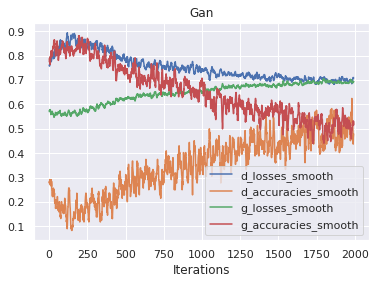

In [22]:
from typing import List

def plot_metric_general(graphs: List[np.ndarray], labels: List[str]) -> None:
    import matplotlib.pyplot as plt
    epochs = range(1, graphs[0].shape[0] + 1)
    plt.xlabel("Iterations")
    plt.title('Gan')
    for i in range(len(labels)):
        plt.plot(epochs, graphs[i])
    plt.legend(labels)
    plt.show()

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


d_losses_smooth, d_accuracies_smooth, g_losses_smooth, g_accuracies_smooth = moving_average(d_losses.reshape((iterations)), 9), moving_average(d_accuracies.reshape((iterations)), 9), moving_average(g_losses.reshape((iterations)), 9), moving_average(g_accuracies.reshape((iterations)), 9)

plot_metric_general([d_losses_smooth, d_accuracies_smooth, g_losses_smooth, g_accuracies_smooth], ['d_losses_smooth', 'd_accuracies_smooth', 'g_losses_smooth', 'g_accuracies_smooth'])
# plot_metric_general([d_losses, d_accuracies, g_losses, g_accuracies], ['d_losses', 'd_accuracies', 'g_losses', 'g_accuracies']) 
# we can see aroud 800 epochs d_fake_accuracies=d_real_accuracies=0.5 and after that it degragates 

In [23]:
import seaborn as sns
sns.set_theme()

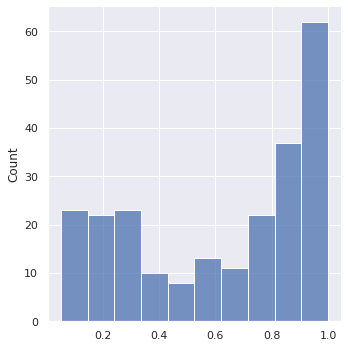

In [24]:
p_proba = gs_rf.predict_proba(df_test)[:,0]
sns.displot(p_proba, bins=10)

In [25]:
print(f'min {min(p_proba)}, max {max(p_proba)}, avg {sum(p_proba)/len(p_proba)}')

min 0.05222159200799896, max 0.999285525240614, avg 0.6224190157120703


In [26]:
smaples_len = 1000
noise = np.random.normal(0, 1, (smaples_len, 10))
c = np.random.uniform(size=(smaples_len, ))
loaded_generator = tf.keras.models.load_model('generator_model.h5')
# samples = gan.generator.predict([noise, c])
samples = loaded_generator.predict([noise, c])

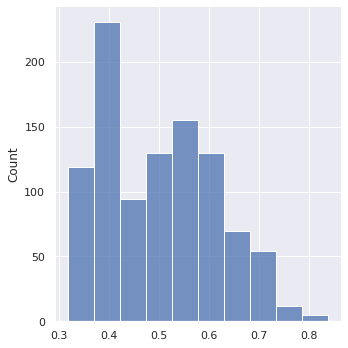

In [27]:
p_proba_s = gs_rf.predict_proba(samples)[:,0]
sns.displot(p_proba_s, bins=10)

In [28]:
print(f'min {min(p_proba_s)}, max {max(p_proba_s)}, avg {sum(p_proba_s)/len(p_proba_s)}')

min 0.3178514604646184, max 0.8395422849951392, avg 0.49962123287162397


In [ ]:
# will be a little bit hard to explain... the distribution is not the same at all.
# got various different results from a couple of runs
# for sure one of the other architecures will give a better results